In [1]:
import pandas as pd
from sqlalchemy import create_engine, text


In [2]:
user = os.environ.get("DB_USER")
pw = os.environ.get("DB_PASSWORD")
db = os.environ.get("DB_USER")
host = os.environ.get("DB_HOST")
port = os.environ.get("DB_PORT")


uri = f"postgresql+psycopg2://{user}:{pw}@{host}:{port}/{db}"
engine = create_engine(uri)


In [3]:
query = text("SELECT * FROM records_5min_clean;")
conn = engine.connect()
df = pd.read_sql(query, conn)
conn.close()

In [4]:
# df.drop(['ambient_humidity', 'ambient_temperature'], axis=1, inplace=True)
df.drop(['ambient_humidity', 'ambient_temperature', 'voc_index', 'nox_index'], axis=1, inplace=True)
# df.drop(['voc_index', 'nox_index'], axis=1, inplace=True)

In [5]:
df.columns

Index(['time', 'device_id', 'mass_concentration_pm1p0',
       'mass_concentration_pm2p5', 'mass_concentration_pm4p0',
       'mass_concentration_pm10p0', 'hour', 'minute_of_hour', 'day_of_week',
       'day_name'],
      dtype='object')

In [6]:
cols = ['mass_concentration_pm1p0', 'mass_concentration_pm2p5', 'mass_concentration_pm4p0', 'mass_concentration_pm10p0']
print(len(df))

for col in cols:
  df.loc[df[col] > 100, col] = 100


41128


In [7]:
# df.loc[df['nox_index'] > 10, 'nox_index'] = 10

In [8]:
df.describe()

,device_id,mass_concentration_pm1p0,mass_concentration_pm2p5,mass_concentration_pm4p0,mass_concentration_pm10p0,hour,minute_of_hour,day_of_week
count,41128.000000,41128.000000,41128.000000,41128.000000,41128.000000,41128.000000,41128.000000,41128.000000
mean,34.703049,13.405850,14.642389,15.137848,15.380163,11.519986,27.478603,3.962848
std,3.032076,13.624296,14.108522,14.073537,14.068942,6.926753,17.251324,2.048630
min,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,32.000000,4.269167,5.322222,5.850000,6.066667,6.000000,10.000000,2.000000
50%,34.000000,8.200000,9.300000,10.022222,10.310000,11.000000,25.000000,4.000000
75%,37.000000,16.800000,17.824167,18.200000,18.550000,18.000000,40.000000,6.000000
max,40.000000,100.000000,100.000000,100.000000,100.000000,23.000000,55.000000,7.000000


Column transformer and the pipeline

In [9]:
from pickle import TRUE
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
import datetime as dt

#### Building a pipeline
class LSTMInputSequenceCreator(BaseEstimator, TransformerMixin):
    def __init__(self, sequence_length, location_col='pass_location_nickname', max_interval=dt.timedelta(minutes=30),stride=1):
        """
            Args:
                sequence_length (int): The length of every LSTM sequence
                max_interval (datetime.Timedelta): The maximum allowed difference between the delta between two consecutive timestamps and the mode delta to impute
                stride (int): The number of steps to move the sequence window by
        """
        self.sequence_length = sequence_length
        self.stride = stride
        self.interval_length = None
        self.allowed_interval_error = max_interval
        self.location_col = location_col
        self.columns = None

    def fit(self, X, y=None):
        self.columns = X.columns
        try:
            X = [x for x in self._split_dataframe_by_location(X)]
            print('N locations: ', len(X))
            self.set_interval_length(X)
        except KeyError:
            self.set_interval_length(X)
        return self

    def transform(self, X):
        print('Transforming')
        X = self.split_dataframe(X)
        print("Dataframe splitted")
        sequences = []
        targets = []

        processed = 0
        for i in range(len(X)):
            X[i] = self.interpolate_missing_timestamps(X[i])
            processed += len(X[i])
            if len(X[i]) < self.sequence_length:
                continue
            sequence, target = self._create_3d_array(X[i])
            sequences.append(sequence)
            targets.append(target)
            print(f'{processed} number of datapoints processed')
        sequences = np.concatenate(sequences)
        targets = np.concatenate(targets)
        return sequences, targets

    def type_check(self, dataframe):
        # Check if the index is a DateTimeIndex
        if isinstance(dataframe.index, pd.DatetimeIndex):
            # Check if all columns are int, float, or transformable to int or float
            if all(dataframe[col].dtype in [np.int64, np.float64] or pd.to_numeric(dataframe[col], errors='raise') for col in dataframe.columns):
                return dataframe.apply(pd.to_numeric, errors='raise')
            else:
                raise ValueError("The index is a DateTimeIndex, but some columns are not int, float, or transformable to int or float.")
        else:
            raise ValueError("The index is not a DateTimeIndex.")



    def interpolate_missing_timestamps(self, df):
        """
            Takes a list of dataframes and checks for missing timestamps
            If there are missing timestamps, the missing timestamps are imputed by linear interpolation
        """
        df = self.type_check(df)
        new_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq=self.interval_length)
        df_reindexed = df.reindex(df.index.union(new_index)).sort_index()

        new_df = df_reindexed.interpolate(method='time')
        new_df = new_df.reindex(new_index)

        return new_df

    def _create_3d_array(self, dataframe, drop_time=True):
        """
            Creates LSTM input sequences from a dataframe

            Args:
                dataframe (pd.DataFrame): The sequence dataframe
                drop_time (Boolean): Determines if the Day and Week columns should be dropped from the targets

            Returns:
                tuple(np.Array, np.Array): A tuple containing the sequences and the targets which are the consecutive values of the sequences
        """
        sequences = None
        targets = None

        # Convert dataframe to numpy array
        if isinstance(dataframe, pd.DataFrame):
            data = dataframe.values
            columns = dataframe.columns
            if drop_time:
              keep_columns = [i for i, col in enumerate(columns) if 'day' not in col and 'hour' not in col]

        elif isinstance(dataframe, np.ndarray):
            data = dataframe
            if drop_time:
              raise ValueError('The time columns can only be dropped if the input data is a dataframe')

        else:
            raise ValueError("The dataframe must be a pandas dataframe or a numpy array")
        # Create sequences
        for i in range(0, len(data) - self.sequence_length, self.stride):
            sequence = data[i:i+self.sequence_length]
            n, f = sequence.shape
            sequence = sequence.reshape((1, n, f))
            target = data[i+self.sequence_length]

            if drop_time:
              target = target[keep_columns]

            out = len(target)
            target = target.reshape((1, out))
            if sequences is None:
                sequences = sequence
                targets = target
            else:
                sequences = np.concatenate([sequences, sequence])
                targets = np.concatenate([targets, target])

        # Convert sequences and targets to numpy arrays
        return sequences, targets

    def set_interval_length(self, data):
        """
            Sets the mode interval length of the dataframe

            Args:
                dataframe (pd.DataFrame): The sequence dataframe
                on_index (bool): If True, the interval length will be set based on the index of the dataframe which should be a timeseries
                timestamp_column (str): The name of the column to use as the timestamp (only applicable if 'on_index' is False)
        """
        if type(data) == list:
            for df in data:

                if type(df) != pd.DataFrame:
                    raise ValueError("All elements of the list must be pandas dataframes")
                if not isinstance(df.index, pd.DatetimeIndex):
                    raise ValueError("The index of the dataframes must be a datetime index")

            self.interval_length = pd.concat([df.index.round('5s').to_series().diff() for df in data]).mode().squeeze()




        elif type(data) == pd.DataFrame:
            if not isinstance(data.index, pd.DatetimeIndex):
                raise ValueError("The index of the dataframe must be a datetime index")
            self.interval_length = data.index.round('5s').to_series().diff().mode().squeeze()


    def _split_dataframe_by_location(self, df):
        """
            Splits a dataframe into sub-dataframes based on the location_nickname column
        """
        for name in df[self.location_col].unique():
            yield name, df[df[self.location_col] == name].drop(columns=self.location_col)


    def split_dataframe(self, dataframe):

        new_dataframes = []
        previous_timestamp = None
        current_group = []
        total = 0
        if self.location_col in dataframe.columns:

            for name, df in self._split_dataframe_by_location(dataframe):
                print(f'Total splitted: {total}')
                total += len(df)
                for timestamp in df.index:
                    if previous_timestamp is None:
                        current_group.append(timestamp)
                        previous_timestamp = timestamp

                    else:

                        timedelta = timestamp - previous_timestamp

                        if timedelta > self.allowed_interval_error:
                            new_dataframes.append(df.loc[current_group])
                            current_group = []
                            current_group.append(timestamp)
                            previous_timestamp = timestamp

                        else:
                            current_group.append(timestamp)
                            previous_timestamp = timestamp

                new_dataframes.append(df.loc[current_group])
                current_group = []
                previous_timestamp = None
        else:
            raise(ValueError(f"The dataframe must have a {self.location_col} column, the other option is not yet implemented"))
        return new_dataframes

In [10]:

# mm_cols = ['mass_concentration_pm1p0', 'mass_concentration_pm2p5', 'mass_concentration_pm4p0', 'mass_concentration_pm10p0','voc_index', 'nox_index']
# mm_cols = ['mass_concentration_pm1p0', 'mass_concentration_pm2p5', 'mass_concentration_pm4p0', 'mass_concentration_pm10p0','ambient_humidity','ambient_temperature']
mm_cols = ['mass_concentration_pm1p0', 'mass_concentration_pm2p5', 'mass_concentration_pm4p0', 'mass_concentration_pm10p0']
# mm_cols = ['voc_index', 'ambient_humidity','ambient_temperature', 'nox_index']
cat_cols = ['hour', 'day_of_week']

col_trans = ColumnTransformer([('mm_scaler', MinMaxScaler(), mm_cols), ('time', OneHotEncoder(sparse_output=False), cat_cols),  ('pass', 'passthrough',  ['device_id'])],remainder='drop')
col_trans.set_output(transform='pandas')


ColumnTransformer(transformers=[('mm_scaler', MinMaxScaler(),
                                 ['mass_concentration_pm1p0',
                                  'mass_concentration_pm2p5',
                                  'mass_concentration_pm4p0',
                                  'mass_concentration_pm10p0']),
                                ('time', OneHotEncoder(sparse_output=False),
                                 ['hour', 'day_of_week']),
                                ('pass', 'passthrough', ['device_id'])])

In [11]:
all_data = df

In [12]:
all_data.columns

Index(['time', 'device_id', 'mass_concentration_pm1p0',
       'mass_concentration_pm2p5', 'mass_concentration_pm4p0',
       'mass_concentration_pm10p0', 'hour', 'minute_of_hour', 'day_of_week',
       'day_name'],
      dtype='object')

In [13]:
print(len(all_data))
col_trans.fit(all_data)

41128


ColumnTransformer(transformers=[('mm_scaler', MinMaxScaler(),
                                 ['mass_concentration_pm1p0',
                                  'mass_concentration_pm2p5',
                                  'mass_concentration_pm4p0',
                                  'mass_concentration_pm10p0']),
                                ('time', OneHotEncoder(sparse_output=False),
                                 ['hour', 'day_of_week']),
                                ('pass', 'passthrough', ['device_id'])])

In [14]:
all_data.index = pd.to_datetime(all_data['time'])
new_data = col_trans.transform(all_data)
new_data.isna().sum()

mm_scaler__mass_concentration_pm1p0     0
mm_scaler__mass_concentration_pm2p5     0
mm_scaler__mass_concentration_pm4p0     0
mm_scaler__mass_concentration_pm10p0    0
time__hour_0.0                          0
time__hour_1.0                          0
time__hour_2.0                          0
time__hour_3.0                          0
time__hour_4.0                          0
time__hour_5.0                          0
time__hour_6.0                          0
time__hour_7.0                          0
time__hour_8.0                          0
time__hour_9.0                          0
time__hour_10.0                         0
time__hour_11.0                         0
time__hour_12.0                         0
time__hour_13.0                         0
time__hour_14.0                         0
time__hour_15.0                         0
time__hour_16.0                         0
time__hour_17.0                         0
time__hour_18.0                         0
time__hour_19.0                   

In [15]:
new_data.dropna(inplace=True)

In [16]:
############## Test vs Train
train = []
test = []

for id, df in new_data.groupby('pass__device_id', as_index=False):
    split = int(len(df) * 0.8)
    train.append(df.iloc[:split])
    test.append(df.iloc[split:])

train_df = pd.concat(train)
test_df = pd.concat(test)



In [17]:
len(train_df)

32898

In [18]:
lstm_formatter = LSTMInputSequenceCreator(sequence_length=20, location_col='pass__device_id', max_interval=dt.timedelta(minutes=30) ,stride=1)
dataframes = lstm_formatter.split_dataframe(new_data)

Total splitted: 0
Total splitted: 7026
Total splitted: 12956
Total splitted: 18437
Total splitted: 23607
Total splitted: 25584
Total splitted: 27606
Total splitted: 31284
Total splitted: 33823
Total splitted: 37530


In [19]:
dataframes[0]

,mm_scaler__mass_concentration_pm1p0,mm_scaler__mass_concentration_pm2p5,mm_scaler__mass_concentration_pm4p0,mm_scaler__mass_concentration_pm10p0,time__hour_0.0,time__hour_1.0,time__hour_2.0,time__hour_3.0,time__hour_4.0,time__hour_5.0,...,time__hour_21.0,time__hour_22.0,time__hour_23.0,time__day_of_week_1.0,time__day_of_week_2.0,time__day_of_week_3.0,time__day_of_week_4.0,time__day_of_week_5.0,time__day_of_week_6.0,time__day_of_week_7.0
time,,,,,,,,,,,,,,,,,,,,,
2024-03-02 10:10:00,0.015500,0.018500,0.020000,0.021000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2024-03-02 10:15:00,0.015500,0.018500,0.020000,0.021000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2024-03-02 10:20:00,0.015500,0.018500,0.020000,0.021000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2024-03-02 10:25:00,0.013750,0.020500,0.025250,0.027750,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2024-03-02 10:30:00,0.013750,0.020500,0.025250,0.027750,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-05 00:00:00,0.099667,0.104556,0.104556,0.104556,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2024-03-05 00:05:00,0.105000,0.110111,0.110111,0.110111,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2024-03-05 00:10:00,0.098000,0.103000,0.103000,0.103000,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [20]:
def create_3d(dataframes):
  sequences = []
  targets = []
  processed = 0

  for i in range(len(dataframes)):

      sequence, target = lstm_formatter._create_3d_array(dataframes[i])
      if sequence is None:
          continue
      sequences.append(sequence)
      targets.append(target)
      processed += len(sequence)
      print(f'Processed {processed} data points')

  sequences = np.concatenate(sequences)
  targets = np.concatenate(targets)
  return sequences, targets

In [21]:
X_train, y_train = create_3d(dataframes)

Processed 727 data points
Processed 5548 data points
Processed 6952 data points
Processed 6954 data points
Processed 8059 data points
Processed 11411 data points
Processed 11420 data points
Processed 12770 data points
Processed 18231 data points
Processed 18255 data points
Processed 21877 data points
Processed 23220 data points
Processed 23267 data points
Processed 23419 data points
Processed 23641 data points
Processed 24276 data points
Processed 25150 data points
Processed 25166 data points
Processed 25240 data points
Processed 25260 data points
Processed 25769 data points
Processed 25820 data points
Processed 25823 data points
Processed 25833 data points
Processed 25836 data points
Processed 26867 data points
Processed 30020 data points
Processed 30148 data points
Processed 30485 data points
Processed 30506 data points
Processed 31515 data points
Processed 31766 data points
Processed 32812 data points
Processed 32821 data points
Processed 32852 data points
Processed 36539 data point

In [22]:
with open('5min/20_30/X_train_pm.npy', 'wb') as f:
    np.save(f, X_train)
with open('5min/20_30/y_train_pm.npy', 'wb') as f:
    np.save(f, y_train)

In [23]:
columns = new_data.columns.tolist()
columns.remove('pass__device_id')
print(columns)

['mm_scaler__mass_concentration_pm1p0', 'mm_scaler__mass_concentration_pm2p5', 'mm_scaler__mass_concentration_pm4p0', 'mm_scaler__mass_concentration_pm10p0', 'time__hour_0.0', 'time__hour_1.0', 'time__hour_2.0', 'time__hour_3.0', 'time__hour_4.0', 'time__hour_5.0', 'time__hour_6.0', 'time__hour_7.0', 'time__hour_8.0', 'time__hour_9.0', 'time__hour_10.0', 'time__hour_11.0', 'time__hour_12.0', 'time__hour_13.0', 'time__hour_14.0', 'time__hour_15.0', 'time__hour_16.0', 'time__hour_17.0', 'time__hour_18.0', 'time__hour_19.0', 'time__hour_20.0', 'time__hour_21.0', 'time__hour_22.0', 'time__hour_23.0', 'time__day_of_week_1.0', 'time__day_of_week_2.0', 'time__day_of_week_3.0', 'time__day_of_week_4.0', 'time__day_of_week_5.0', 'time__day_of_week_6.0', 'time__day_of_week_7.0']


In [24]:
X_train[0][10]

array([0.01411111, 0.01811111, 0.021     , 0.02233333, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ])

(array([588.,  94.,  52.,   5.,   1.,   2.,   3.,   0.,   0.,   2.]),
 array([0.00966667, 0.1087    , 0.20773333, 0.30676667, 0.4058    ,
        0.50483333, 0.60386667, 0.7029    , 0.80193333, 0.90096667,
        1.        ]),
 <BarContainer object of 10 artists>)

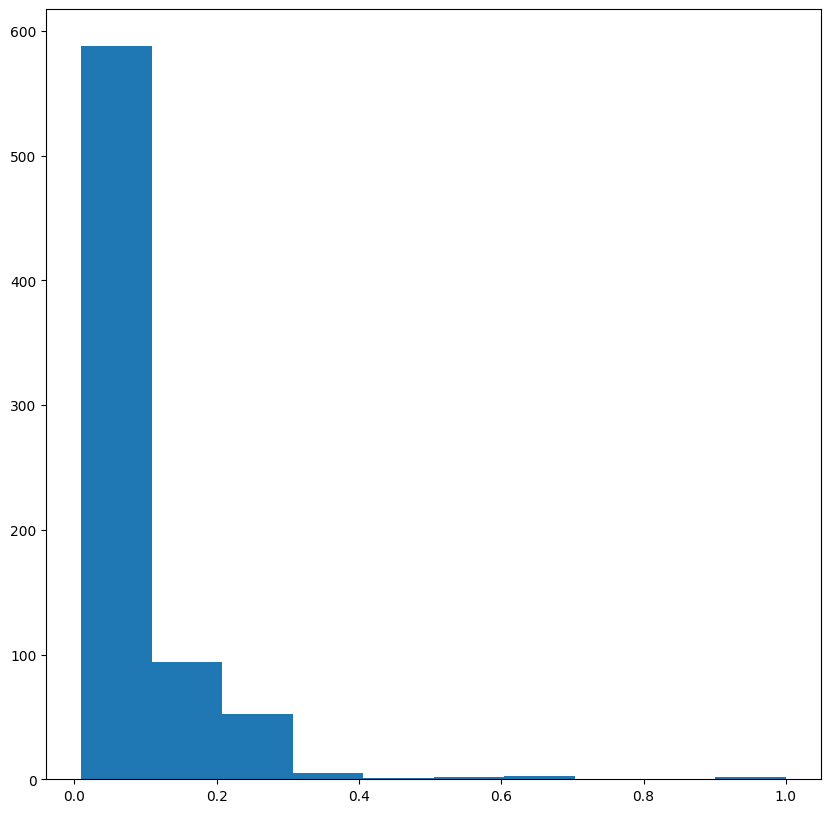

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.hist(dataframes[0]['mm_scaler__mass_concentration_pm1p0'])

In [30]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split



# Define the input shape
input_shape = X_train[0].shape
output_shape = y_train.shape[1]
print('Input shape:', input_shape)

# Define the LSTM-based neural network
inputs = Input(shape=input_shape)
lstm_layer = LSTM(128, return_sequences=True, activation='relu')(inputs)
lstm_layer = LSTM(128, activation='relu')(lstm_layer)
dense = Dense(64, activation='relu')(lstm_layer)
dense = Dense(32, activation='relu')(dense)
output = Dense(output_shape, 'linear')(dense)

# # Define the LSTM-based neural network
# inputs = Input(shape=input_shape)
# lstm_layer = LSTM(128, return_sequences=True, activation='relu')(inputs)
# lstm_layer = LSTM(64, activation='relu')(lstm_layer)
# dense = Dense(32, activation='relu')(lstm_layer)
# dense = Dense(16, activation='relu')(dense)
# output = Dense(output_shape, 'sigmoid')(dense)

# Create the model
model = Model(inputs=inputs, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

# Train the model
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

# Callbacks
early_stopping=EarlyStopping(patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)


model.fit(X_train, y_train, epochs=50, batch_size=128, validation_split=0.1, callbacks=[early_stopping, reduce_lr])

Input shape: (20, 35)
Epoch 1/50
181/181 [==============================] - 19s 77ms/step - loss: 0.0185 - mae: 0.0859 - val_loss: 0.0017 - val_mae: 0.0320 - lr: 1.0000e-04
Epoch 2/50
181/181 [==============================] - 13s 71ms/step - loss: 0.0046 - mae: 0.0339 - val_loss: 0.0013 - val_mae: 0.0261 - lr: 1.0000e-04
Epoch 3/50
181/181 [==============================] - 17s 95ms/step - loss: 0.0042 - mae: 0.0302 - val_loss: 0.0012 - val_mae: 0.0251 - lr: 1.0000e-04
Epoch 4/50
181/181 [==============================] - 13s 73ms/step - loss: 0.0041 - mae: 0.0292 - val_loss: 0.0011 - val_mae: 0.0242 - lr: 1.0000e-04
Epoch 5/50
181/181 [==============================] - 13s 74ms/step - loss: 0.0040 - mae: 0.0283 - val_loss: 0.0011 - val_mae: 0.0245 - lr: 1.0000e-04
Epoch 6/50
181/181 [==============================] - 13s 73ms/step - loss: 0.0039 - mae: 0.0278 - val_loss: 0.0012 - val_mae: 0.0257 - lr: 1.0000e-04
Epoch 7/50
181/181 [==============================] - 14s 75ms/step - lo

In [27]:
X_test = {}
y_test = {}
for id, df in test_df.groupby('pass__device_id', as_index=True):
  df = df.drop(columns=['pass__device_id'])
  x, y = create_3d([df])
  X_test[id] = x
  print(x[0][0])
  y_test[id] = y


Processed 1386 data points
[0.07444444 0.09622222 0.11133333 0.11877778 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.        ]
Processed 1166 data points
[0.0345 0.0515 0.065  0.0715 0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     1.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     1.     0.    ]
Processed 1077 data points
[0.0397 0.0425 0.0436 0.0439 0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     1.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     1.     0.    ]
Processed 1014 data points
[0.045  0.0505 0.053  0.055  0.     0.     0.     0.     0.     

In [28]:
evaluations = {}
for id, x in X_test.items():
  loss = model.evaluate(x=x, y=y_test[id])
  evaluations[id] = loss +[len(x)]

22/22 [==============================] - 0s 3ms/step - loss: 0.0010 - mae: 0.0164


In [29]:
for id, loss in evaluations.items():
  print(f'Device id: {id}\nMean absolute error: {loss[1]}\nTest data lenght: {loss[2]}\n\n')

Device id: 31
Mean absolute error: 0.023610597476363182
Test data lenght: 1386


Device id: 32
Mean absolute error: 0.015533283352851868
Test data lenght: 1166


Device id: 33
Mean absolute error: 0.017670154571533203
Test data lenght: 1077


Device id: 34
Mean absolute error: 0.01541066449135542
Test data lenght: 1014


Device id: 35
Mean absolute error: 0.01882864162325859
Test data lenght: 376


Device id: 36
Mean absolute error: 0.02072647400200367
Test data lenght: 385


Device id: 37
Mean absolute error: 0.01250525563955307
Test data lenght: 716


Device id: 38
Mean absolute error: 0.02257518842816353
Test data lenght: 488


Device id: 39
Mean absolute error: 0.013251611031591892
Test data lenght: 722


Device id: 40
Mean absolute error: 0.016362132504582405
Test data lenght: 700


